# Construction modèle

In [28]:
from cnn_model import build_model
model, base_model = build_model(img_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-m (Function  (None, 8, 8, 1280)        53150388  
 al)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 81920)             0         
                                                                 
 dropout_8 (Dropout)         (None, 81920)             0         
                                                                 
 dense_10 (Dense)            (None, 2048)              167774208 
                                                                 
 dropout_9 (Dropout)         (None, 2048)              0         
                                                                 
 dense_11 (Dense)            (None, 1024)              2098176   
                                                      

# Entrainement du modèle

### Callbacks

In [15]:
# earlystopping défini pour réduire le temps d'entrainement si l'accuracy n'évolue plus.
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor = 'accuracy',
                               min_delta = 0.05,
                               patience = 8,
                               verbose = 1,
                               mode = 'auto',
                               restore_best_weights = True)



# Reduction du learning Rate
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduceLR = ReduceLROnPlateau(monitor = 'val_loss',
                             min_delta = 0.01,
                             patience = 5,
                             factor = 0.1,
                             cooldown = 2,
                             mode = 'min',
                             verbose = 2)





# Enregistrement du modèle en cas d'amélioration lors de l'entrainement, ne conserve que la meilleure itération
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath='../model/checkpoint_model',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=False,
                             mode = 'min',
                             save_freq='epoch',
                             verbose=1)




# Suivi du temps d'entrainement
from timeit import default_timer as timer
from tensorflow.keras.callbacks import Callback


class TimingCallback(Callback):
    def __init__(self):
        super().__init__()
        self.logs = []

    def on_epoch_begin(self, epoch, logs=None):
        self.starttime = timer()

    def on_epoch_end(self, epoch, logs=None):
        endtime = timer()
        elapsed_time = endtime - self.starttime
        self.logs.append(elapsed_time)
        print(f"Epoch {epoch + 1} took {elapsed_time:.2f} seconds")

time_callback = TimingCallback()

### Methode .fit

In [29]:
from tensorflow.keras.optimizers import Adam
model.compile(Adam(learning_rate = learning_rate),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [30]:
history = model.fit(dataset_train,
                    validation_data = dataset_val,
                    epochs = epochs,
                    callbacks = [early_stopping, reduceLR, checkpoint, time_callback],
                    verbose=True)

Epoch 1/20
368/368 [==============================] - ETA: 0s - loss: 5.0806 - accuracy: 0.2007
Epoch 1: val_loss did not improve from 3.02804
Epoch 1 took 113.37 seconds
368/368 [==============================] - 113s 241ms/step - loss: 5.0806 - accuracy: 0.2007 - val_loss: 4.3066 - val_accuracy: 0.2850 - lr: 1.0000e-04
Epoch 2/20
368/368 [==============================] - ETA: 0s - loss: 3.9391 - accuracy: 0.2933
Epoch 2: val_loss did not improve from 3.02804
Epoch 2 took 82.19 seconds
368/368 [==============================] - 82s 223ms/step - loss: 3.9391 - accuracy: 0.2933 - val_loss: 3.4033 - val_accuracy: 0.3778 - lr: 1.0000e-04
Epoch 3/20
368/368 [==============================] - ETA: 0s - loss: 3.2083 - accuracy: 0.3509
Epoch 3: val_loss improved from 3.02804 to 2.79560, saving model to ../model/checkpoint_model
Epoch 3 took 173.53 seconds
368/368 [==============================] - 174s 472ms/step - loss: 3.2083 - accuracy: 0.3509 - val_loss: 2.7956 - val_accuracy: 0.4286 - l

### Fine tuning

In [44]:
for layer in base_model.layers:
    layer.trainable = True

model_fine_tuned = model
model_fine_tuned_name = model_name + '_fine_tuned'


model_fine_tuned.compile(Adam(learning_rate = learning_rate),
                         loss = 'sparse_categorical_crossentropy',
                         metrics = ['accuracy'])

In [60]:
fine_tune_epochs = 30
total_epochs =  epochs + fine_tune_epochs

history_fine_tuning = model_fine_tuned.fit(dataset_train,
                                           validation_data = dataset_val,
                                           epochs = total_epochs,
                                           initial_epoch=history.epoch[-1],
                                           callbacks = [early_stopping, reduceLR, checkpoint, time_callback],
                                           verbose=True)

Epoch 30/50
368/368 [==============================] - ETA: 0s - loss: 1.4641 - accuracy: 0.5067
Epoch 30: val_loss did not improve from 1.16285
Epoch 30 took 97.92 seconds
368/368 [==============================] - 98s 266ms/step - loss: 1.4641 - accuracy: 0.5067 - val_loss: 1.4287 - val_accuracy: 0.5209 - lr: 1.0000e-04
Epoch 31/50
368/368 [==============================] - ETA: 0s - loss: 1.4429 - accuracy: 0.5099
Epoch 31: val_loss did not improve from 1.16285
Epoch 31 took 95.63 seconds
368/368 [==============================] - 96s 260ms/step - loss: 1.4429 - accuracy: 0.5099 - val_loss: 1.4071 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 32/50
368/368 [==============================] - ETA: 0s - loss: 1.4197 - accuracy: 0.5194
Epoch 32: val_loss did not improve from 1.16285
Epoch 32 took 95.56 seconds
368/368 [==============================] - 96s 260ms/step - loss: 1.4197 - accuracy: 0.5194 - val_loss: 1.4003 - val_accuracy: 0.5345 - lr: 1.0000e-04
Epoch 33/50
368/368 [=======

# Evaluation

### Model

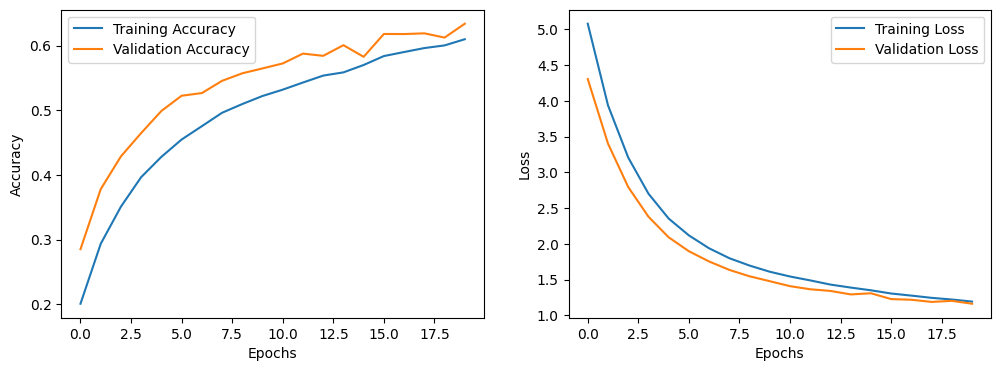

In [31]:
import matplotlib.pyplot as plt

# Courbes d'évolution de l'accuracy et de la val_accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Courbes d'évolution de la loss et de la val_loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
test_results = model.evaluate(dataset_test)
print("Resultats de la prediction:", test_results)

y_pred = model.predict(dataset_test)

32/32 [==============================] - 6s 175ms/step - loss: 1.1508 - accuracy: 0.6365
Resultats de la prediction: [1.1507598161697388, 0.6364536881446838]
32/32 [==============================] - 11s 147ms/step


In [39]:
# Rapport de classification
y_test = []
for _, label in dataset_test:
    y_test.extend(label.numpy())
y_test = np.array(y_test)


y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_classes)
print(report)


              precision    recall  f1-score   support

           0       0.63      0.56      0.60       199
           1       0.63      0.79      0.70       191
           2       0.70      0.46      0.55       212
           3       0.67      0.46      0.54       199
           4       0.75      0.76      0.76       196
           5       0.60      0.62      0.61       216
           6       0.64      0.83      0.72       202
           7       0.52      0.58      0.55       192
           8       0.57      0.62      0.59       204
           9       0.68      0.71      0.70       208

    accuracy                           0.64      2019
   macro avg       0.64      0.64      0.63      2019
weighted avg       0.64      0.64      0.63      2019



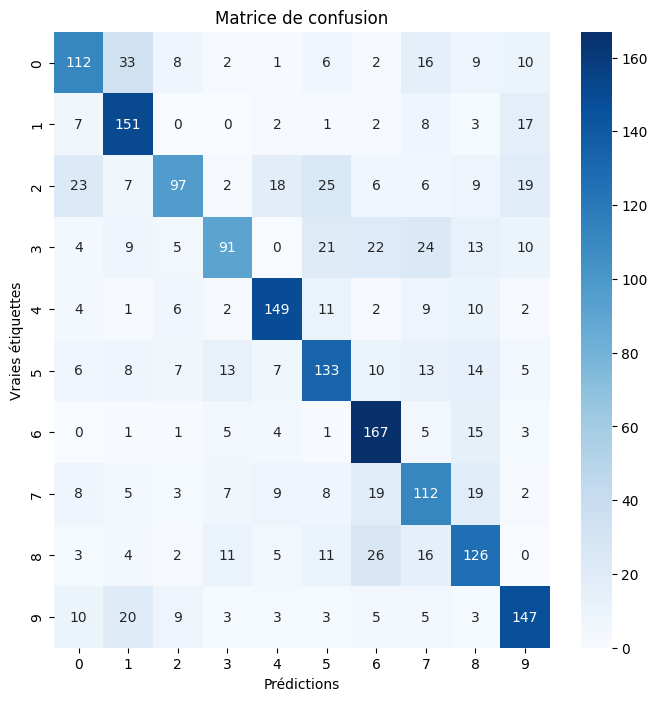

In [40]:
# Matrice de confusion
import seaborn as sns
from sklearn.metrics import confusion_matrix

confusion_mtx = confusion_matrix(y_test, y_pred_classes)
# Créer une figure pour afficher la matrice de confusion
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de confusion')
plt.show()

### Model_fine_tuned

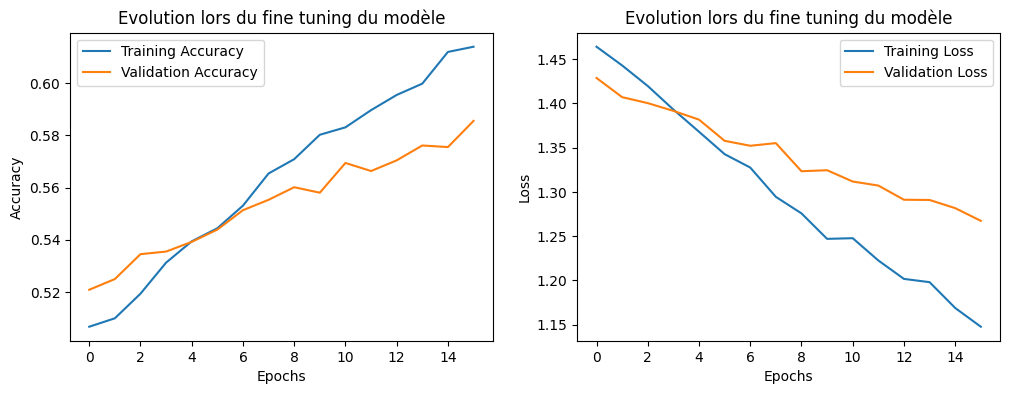

In [61]:
import matplotlib.pyplot as plt

# Courbes d'évolution de l'accuracy et de la val_accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_fine_tuning.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine_tuning.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Evolution lors du fine tuning du modèle')

plt.legend()

# Courbes d'évolution de la loss et de la val_loss
plt.subplot(1, 2, 2)
plt.plot(history_fine_tuning.history['loss'], label='Training Loss')
plt.plot(history_fine_tuning.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution lors du fine tuning du modèle')
plt.legend()
plt.show();

In [62]:
test_results = model_fine_tuned.evaluate(dataset_test)
print("Resultats de la prediction:", test_results)

y_pred = model_fine_tuned.predict(dataset_test)

32/32 [==============================] - 5s 154ms/step - loss: 1.3326 - accuracy: 0.5453
Resultats de la prediction: [1.332647681236267, 0.5453194379806519]
32/32 [==============================] - 5s 148ms/step


In [63]:
# Rapport de classification
y_test = []
for _, label in dataset_test:
    y_test.extend(label.numpy())
y_test = np.array(y_test)


y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_classes)
print(report)


              precision    recall  f1-score   support

           0       0.59      0.46      0.52       199
           1       0.54      0.63      0.58       191
           2       0.54      0.44      0.49       212
           3       0.45      0.44      0.45       199
           4       0.67      0.58      0.62       196
           5       0.50      0.52      0.51       216
           6       0.56      0.76      0.65       202
           7       0.53      0.52      0.52       192
           8       0.59      0.49      0.53       204
           9       0.52      0.62      0.57       208

    accuracy                           0.55      2019
   macro avg       0.55      0.55      0.54      2019
weighted avg       0.55      0.55      0.54      2019



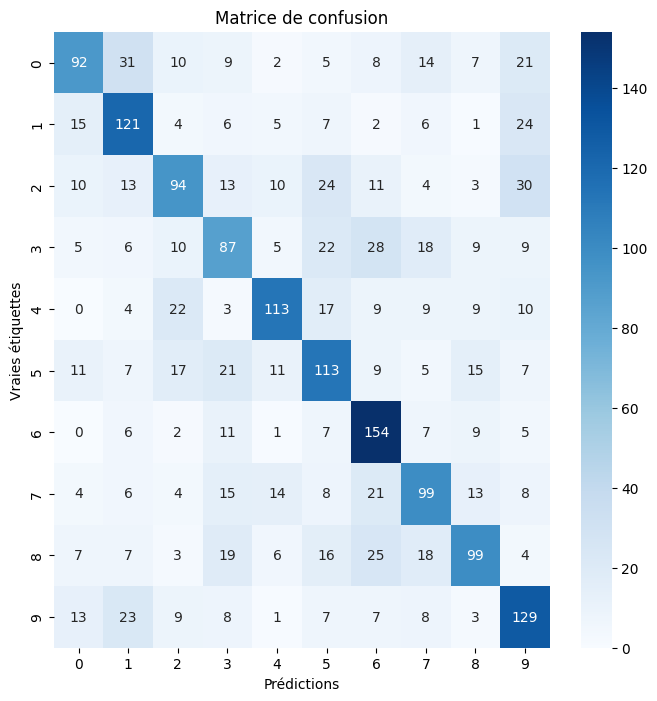

In [64]:
# Matrice de confusion
import seaborn as sns
from sklearn.metrics import confusion_matrix

confusion_mtx = confusion_matrix(y_test, y_pred_classes)
# Créer une figure pour afficher la matrice de confusion
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de confusion')
plt.show()

# Sauvegarde du modèle

In [66]:
print(model_name)
print(model_fine_tuned_name)

/content/drive/MyDrive/SAS/model/V0_tri_full_undersample
V0_tri_full_undersample_fine_tuned
/content/drive/MyDrive/SAS/history/history_fine_tuning.pkl


In [67]:
if work_env == '2':
    model_name = '/content/drive/MyDrive/SAS/model/' + model_name
    model_fine_tuned_name = '/content/drive/MyDrive/SAS/model/' + model_fine_tuned_name
    #history_path = '/content/drive/MyDrive/SAS/history/history.pkl'
    history_fine_tuning_path = '/content/drive/MyDrive/SAS/history/history_fine_tuning.pkl'


else:
    model_name = '../model/' + model_name
    model_fine_tuned_name = '../model/' + model_fine_tuned_name
    history_path = '../history/history.pkl'
    history_fine_tuning_path = '../history/history_fine_tuning.pkl'


model.save(model_name, save_format='h5')


import pickle
with open(history_path, 'wb') as file:
    pickle.dump(history.history, file)

with open(history_fine_tuning_path, 'wb') as file:
    pickle.dump(history_fine_tuning.history, file)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
